In [1]:
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import numpy as np
import pandas as pd

In [38]:
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Last Date: 2017-08-23
Query Date: 2016-08-23


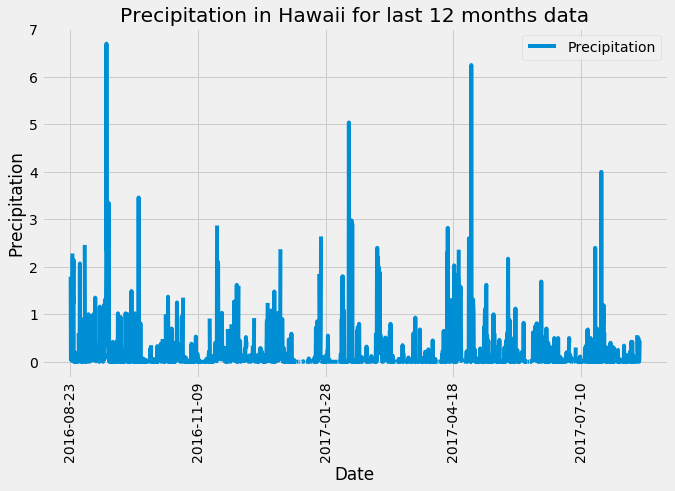

In [64]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Find the last date in the file
lastdate_query = session.query(func.max(Measurement.date)).first()[0]
last_date = datetime.strptime(lastdate_query,'%Y-%m-%d').date()
print("Last Date:", last_date)

# Find the date 1 year from last data point
query_date = last_date - relativedelta(months= 12)
print("Query Date:", query_date)

# Perform a query to retrieve the data and precipitation scores
query_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(query_year, columns = ['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize = (10,6), rot=90, legend=True)
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title("Precipitation in Hawaii for last 12 months data")
plt.savefig('Result/Precipitation data plot.png', bbox_inches = "tight")

In [55]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [56]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
print(f"Number of stations in the dataset: {station_count}")

Number of stations in the dataset: 9


In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = most_active_stations[0][0]
temp_query = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station).all()
temp_query

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

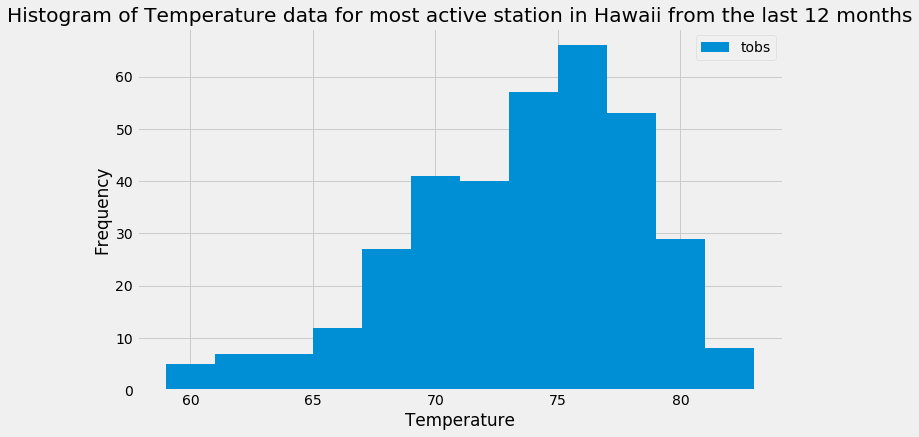

In [95]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data_query = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
filter(Measurement.date >= query_date).all()

# Convert the query to df
mostactive_station_temp_df = pd.DataFrame(temp_data_query, columns = ["tobs"])

# Histogram of Temperature data for most active station
plt.figure(figsize=(10,6))
plt.hist(mostactive_station_temp_df["tobs"], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.title("Histogram of Temperature data for most active station in Hawaii from the last 12 months")
plt.savefig('Result/Histogram of Temperature data for most active station.png', bbox_inches = "tight")

## Bonus Challenge Assignment

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [104]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-08-28'
end_date = '2016-09-02'
trip_temp = calc_temps(start_date,end_date)
print(trip_temp)

[(71.0, 78.35897435897436, 82.0)]


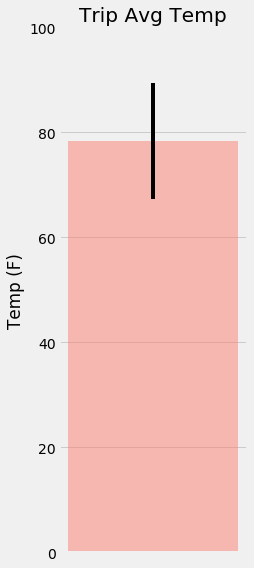

In [145]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temp[0][0]
avg_temp = trip_temp[0][1]
max_temp = trip_temp[0][2]

plt.figure(figsize=(3,9))
plt.bar(1, avg_temp, yerr = (max_temp - min_temp), color="salmon", alpha=0.5)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.ylim(0, 100)
plt.savefig('Result/Bar chart of Trip temperature.png', bbox_inches = "tight")

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
